# MNIST CNN model

- run your model for 25 epochs for each:
- without L1/L2 with BN
- without L1/L2 with GBN
- with L1 with BN
- with L1 with GBN
- with L2 with BN
- with L2 with GBN
- with L1 and L2 with BN
- with L1 and L2 with GBN

## Connecting drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [0]:
import os
os.chdir("./drive/My Drive/EVA/Session05")

## Importing Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from torchvision import datasets, transforms

from torchsummary import summary
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)

## GPU for training

In [4]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

try:
  print(f"Found GPU at : {device_name}")
except:
  print("GPU device not found.")

Found GPU at : /device:GPU:0


In [5]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  use_cuda = True
  print(f"Number of GPU's available : {torch.cuda.device_count()}")
  print(f"GPU device name : {torch.cuda.get_device_name(0)}")
else:
  print("No GPU available, using CPU instead")
  device = torch.device("cpu")
  use_cuda = False

Number of GPU's available : 1
GPU device name : Tesla P100-PCIE-16GB


In [6]:
SEED = 1
torch.manual_seed(SEED)

## Data Transformation

In [0]:
#training data transformation

train_transforms = transforms.Compose([
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-6,6), fill=(1,)),
                                       #transforms.RandomAffine(degrees=0, translate=(0.2,0.2)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,))
])

test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,)),
])


## Downloading MNIST dataset with applied transformation

Things to keep in mind, 
- the dataset is provided by pytorch community.
- MNIST dataset contains: 
  - 60,000 training images
  - 10,000 test images 
  - Each image is of size (28x28x1).
- The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation for MNIST dataset.

## Train and Test Dataloader 

In [0]:
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

In [0]:
class Dataset:
  def __init__(self, batch_size):
    self.mnist_trainset = datasets.MNIST(root="./data", train=True, download=True,
                                transform=train_transforms)

    self.mnist_testset = datasets.MNIST(root="./data", train=False, download=True,
                               transform=test_transforms)
    
    self.batch_size = batch_size
    
  def get_train_loader(self):
    train_loader = torch.utils.data.DataLoader(self.mnist_trainset,
                                          batch_size=self.batch_size, shuffle=True, **kwargs)
    
    return train_loader
    
  def get_test_loader(self):
    test_loader = torch.utils.data.DataLoader(self.mnist_testset,
                                          batch_size=self.batch_size, shuffle=True, **kwargs)
    
    return test_loader
    

## Visualization of images

In [0]:
data = Dataset(64)
examples = iter(data.get_train_loader())
example_data, example_targets = examples.next()

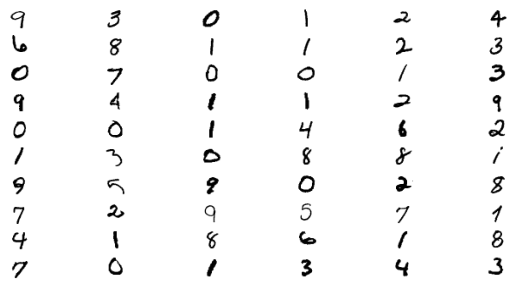

In [11]:
fig = plt.figure()
for i in range(60):
  plt.subplot(10,6,i+1)
  plt.axis('off')
  plt.imshow(example_data[i][0].numpy().squeeze(), cmap='gray_r')

## Building the model

### Util function

In [0]:
#define batch normalization
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias
        

#define ghost batch Normalization
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits=1, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

### Define Net with nn.BatchNorm2d()

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1block = nn.Sequential(
            nn.Conv2d(1, 8, 3),                            #(-1,28,28,1)>(-1,3,3,1,8)>(-1,26,26,8)>3
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3),                           #(-1,26,26,8)>(-1,3,3,8,8)>(-1,24,24,8)>5
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 10, 3),                           #(-1,24,24,8)>(-1,3,3,8,10)>(-1,22,22,10)>7
            nn.BatchNorm2d(10),
            nn.ReLU(),
        )

        self.pool1block = nn.Sequential(
            nn.MaxPool2d(2,2),                              #(-1,22,22,10)>(-1,11,11,10)>8
        )

        self.conv2block = nn.Sequential(
            nn.Conv2d(10, 16, 3),                           #(-1,11,11,10)>(-1,3,3,10,16)>(-1,9,9,16)>12
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Conv2d(16, 16, 3),                           #(-1,9,9,16)>(-1,3,3,16,16)>(-1,7,7,16)>16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Conv2d(16, 16, 3),                           #(-1,7,7,16)>(-1,3,3,16,16)>(-1,5,5,16)>20
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.01),
        )

        self.avgpool = nn.AvgPool2d(5)                      #(-1,5,5,16)>(-1,1,1,16)>28
        self.conv3 = nn.Conv2d(16, 10, 1)                   #(-1,1,1,16)>(-1,1,1,16,10)>(-1,1,1,10)>28  

        
    def forward(self, x):
        x = self.conv1block(x)
        x = self.pool1block(x)
        x = self.conv2block(x)
        x = self.avgpool(x)
        x = self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)


### Define Network with Ghost Batch Normalization

In [0]:
class GhostNet(nn.Module):
    def __init__(self, n_splits=1):
        super(GhostNet, self).__init__()
        
        self.conv1block = nn.Sequential(
            nn.Conv2d(1, 8, 3),                            #(-1,28,28,1)>(-1,3,3,1,8)>(-1,26,26,8)>3
            GhostBatchNorm(8, n_splits),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3),                           #(-1,26,26,8)>(-1,3,3,8,8)>(-1,24,24,8)>5
            GhostBatchNorm(8, n_splits),
            nn.ReLU(),
            nn.Conv2d(8, 10, 3),                           #(-1,24,24,8)>(-1,3,3,8,10)>(-1,22,22,10)>7
            GhostBatchNorm(10, n_splits),
            nn.ReLU(),
        )

        self.pool1block = nn.Sequential(
            nn.MaxPool2d(2,2),                              #(-1,22,22,10)>(-1,11,11,10)>8
        )

        self.conv2block = nn.Sequential(
            nn.Conv2d(10, 16, 3),                           #(-1,11,11,10)>(-1,3,3,10,16)>(-1,9,9,16)>12
            GhostBatchNorm(16, n_splits),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Conv2d(16, 16, 3),                           #(-1,9,9,16)>(-1,3,3,16,16)>(-1,7,7,16)>16
            GhostBatchNorm(16, n_splits),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Conv2d(16, 16, 3),                           #(-1,7,7,16)>(-1,3,3,16,16)>(-1,5,5,16)>20
            GhostBatchNorm(16, n_splits),
            nn.ReLU(),
            nn.Dropout(0.01),
        )

        self.avgpool = nn.AvgPool2d(5)                      #(-1,5,5,16)>(-1,1,1,16)>28
        self.conv3 = nn.Conv2d(16, 10, 1)                   #(-1,1,1,16)>(-1,1,1,16,10)>(-1,1,1,10)>28  

        
    def forward(self, x):
        x = self.conv1block(x)
        x = self.pool1block(x)
        x = self.conv2block(x)
        x = self.avgpool(x)
        x = self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [15]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             584
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             730
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,456
      BatchNorm2d-12             [-1, 16, 9, 9]              32
             ReLU-13             [-1, 16, 9, 9]               0
          Dropout-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Defining training and testing functions

### Util functions

In [0]:
def regularize_loss(model, loss, decay, norm_value):
  """
  L1/L2 Regularization
  decay : l1/l2 decay value
  norm_value : the order of norm
  """
  r_loss = 0
  # get sum of norm of parameters
  for param in model.parameters():
    r_loss += torch.norm(param, norm_value)
  # update loss value
  loss += decay * r_loss
  
  return loss

In [0]:
def save_ckp(state, checkpoint_fpath):
    """
    state: checkpoint we want to save
    checkpoint_path: path to save model
    """
    f_path = checkpoint_fpath
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # get epoch
    epoch = checkpoint['epoch']
    # get val_max_acc
    val_max_acc = checkpoint['valid_max_acc']
    # get misclassified images
    misclassified_images = checkpoint['misclassified_images']
    # return model, optimizer, epoch, val_max_acc, misclassified_images
    return model, optimizer, epoch, val_max_acc, misclassified_images

### Define Training and Testing Functions

In [0]:
from tqdm import tqdm
import numpy as np

class Model:
  def __init__(self, model, device, optimizer, l1_decay=0.0, l2_decay=0.0):
    self.model = model
    self.device = device
    self.optimizer = optimizer
    
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    
    self.misclassified_images = {}
    
    self.l1_decay = l1_decay
    self.l2_decay = l2_decay

    self.minimum_test_loss = np.Inf
    self.maximum_test_acc = 0.0


  def train(self, train_loader):
      running_loss = 0.0
      running_correct = 0

      self.model.train()

      pbar = tqdm(train_loader)
      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(self.device), target.to(self.device)
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)

          if self.l1_decay>0.0:
            loss += regularize_loss(self.model, loss, self.l1_decay, 1)
          if self.l2_decay>0.0:
            loss += regularize_loss(self.model, loss, self.l2_decay, 2)

          _, preds = torch.max(output.data, 1)
          loss.backward()
          self.optimizer.step()

          #calculate training running loss
          running_loss += loss.item()
          running_correct += (preds == target).sum().item()
          pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

      r_total_loss = running_loss/len(train_loader.dataset)
      r_total_acc = 100. * running_correct/len(train_loader.dataset)

      self.train_losses.append(r_total_loss)
      self.train_acc.append(r_total_acc)
      print("\n")
      print(f"  TRAIN avg loss: {r_total_loss:.4f} train acc: {r_total_acc:.4f}\n")

  def test(self, test_loader, epoch, checkpoint_fpath = None):
      running_loss = 0.0
      running_correct = 0

      self.model.eval()
      
      with torch.no_grad():
          for data, target in test_loader:
              data, target = data.to(self.device), target.to(self.device)
              output = self.model(data)
              running_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              
              is_correct = pred.eq(target.view_as(pred))
              misclass_indx = (is_correct==0).nonzero()[:,0]
              for indx in misclass_indx:
                if str(epoch) not in self.misclassified_images:
                  self.misclassified_images[str(epoch)] = []
                self.misclassified_images[str(epoch)].append({
                    "target" : target[indx],
                    "pred" : pred[indx],
                    "img" : data[indx]
                })

              running_correct += pred.eq(target.view_as(pred)).sum().item()

      r_total_loss = running_loss/len(test_loader.dataset)
      r_total_acc = 100.*running_correct/len(test_loader.dataset)

      if(r_total_acc>=self.maximum_test_acc):
        self.maximum_test_acc = r_total_acc
        if checkpoint_fpath:
          self.save_checkpoint(epoch, checkpoint_fpath)
          print(f"  Best Model Saved!!!\n")
        else:
          print(f"  Couldn't save the model. Path not defined!!!\n")
        

      self.test_losses.append(r_total_loss)
      self.test_acc.append(r_total_acc)

      print("\n")
      print(f"  TEST avg loss: {r_total_loss:.4f} test acc: {r_total_acc:.4f}\n")

  def save_checkpoint(self, epoch, checkpoint_fpath):
    checkpoint = {
          'epoch' : epoch,
          'misclassified_images' : self.misclassified_images[str(epoch)],
          'valid_max_acc': self.maximum_test_acc,
          'state_dict': self.model.state_dict(),
          'optimizer': self.optimizer.state_dict(),
      }
    save_ckp(checkpoint, checkpoint_fpath)

## Main Running Function

In [0]:
import json
import os

def run(condition, l1_decay, l2_decay, n_splits=1):
  """
  condition : jobs mentioned for problem statement
  l1_decay : decay factor for l1 norm
  l2_decay : decay factor for l2 norm
  n_splits : mini batch splits
  """
  print("\n")
  print("#"*50 + "\n")
  print(f"{condition}")
  print("-"*50 + "\n")
  
  if "gbn" in condition:
    net = GhostNet(n_splits).to(device)
    batch_size = 256
  else:
    net = Net().to(device)
    batch_size = 128

  data = Dataset(batch_size)
  train_loader = data.get_train_loader()
  test_loader = data.get_test_loader()
  
  optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=9, gamma=0.1)
  EPOCHS = 25

  model = Model(net, device, optimizer, l1_decay, l2_decay)
  MODEL_PATH = f"./weights/model_{condition}.pt"

  for epoch in range(1, EPOCHS+1):
    print(f"\nEPOCH : {epoch}\n")
    model.train(train_loader)
    scheduler.step()
    model.test(test_loader, epoch, MODEL_PATH)

  result = {f'{condition}':{'train_losses':model.train_losses, 'test_losses':model.test_losses,
                            'train_acc':model.train_acc, 'test_acc':model.test_acc}}

  
  file_path = "./stats/models_acc_losses_data.json"
  if not os.path.exists(file_path):
    with open(file_path, "w") as f:
      json.dump({'status':200}, f)

  with open(file_path) as f:
    data = json.load(f)
    
  data.update(result)
  with open(file_path, "w") as f:
      json.dump(data, f)

  print("#"*10 + "\n")

In [20]:
n_splits = 16

run('n_l1_n_l2_bn', 0.0, 0.0, 1)
run('n_l1_n_l2_gbn', 0.0, 0.0, n_splits)
run('l1_bn', 0.0005, 0.0, 1)
run('l1_gbn', 0.0005, 0.0, n_splits)
run('l2_bn', 0.0, 0.0005, 1)
run('l2_gbn', 0.0, 0.0005, n_splits)
run('l1_l2_bn', 0.0005, 0.0005, 1)
run('l1_l2_gbn', 0.0005, 0.0005, n_splits)

  0%|          | 0/469 [00:00<?, ?it/s]



##################################################

n_l1_n_l2_bn
--------------------------------------------------


EPOCH : 1



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.05529120936989784 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.18it/s]



  TRAIN avg loss: 0.0016 train acc: 94.1633




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0743 test acc: 97.5500


EPOCH : 2



loss=0.009215201251208782 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.89it/s]



  TRAIN avg loss: 0.0004 train acc: 98.3950




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0387 test acc: 98.7800


EPOCH : 3



loss=0.04719700291752815 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.12it/s]



  TRAIN avg loss: 0.0003 train acc: 98.8383




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0333 test acc: 98.8500


EPOCH : 4



loss=0.030238056555390358 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.34it/s]




  TRAIN avg loss: 0.0003 train acc: 98.9967



  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0266 test acc: 99.2000


EPOCH : 5



loss=0.025517309084534645 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.00it/s]



  TRAIN avg loss: 0.0002 train acc: 99.0833




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0267 test acc: 99.2100


EPOCH : 6



loss=0.017988869920372963 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.99it/s]



  TRAIN avg loss: 0.0002 train acc: 99.1433




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0259 test acc: 99.1600


EPOCH : 7



loss=0.02133217640221119 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.88it/s]



  TRAIN avg loss: 0.0002 train acc: 99.2383




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0253 test acc: 99.2400


EPOCH : 8



loss=0.014646634459495544 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.08it/s]



  TRAIN avg loss: 0.0002 train acc: 99.2717




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0278 test acc: 99.1400


EPOCH : 9



loss=0.021162712946534157 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.72it/s]



  TRAIN avg loss: 0.0002 train acc: 99.3483




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0233 test acc: 99.3000


EPOCH : 10



loss=0.02476133406162262 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.53it/s]



  TRAIN avg loss: 0.0001 train acc: 99.5683




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0201 test acc: 99.3900


EPOCH : 11



loss=0.0004140635428484529 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.50it/s]



  TRAIN avg loss: 0.0001 train acc: 99.6633




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0187 test acc: 99.4300


EPOCH : 12



loss=0.010036383755505085 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.64it/s]



  TRAIN avg loss: 0.0001 train acc: 99.6667




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0182 test acc: 99.4500


EPOCH : 13



loss=0.0017372866859659553 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.53it/s]



  TRAIN avg loss: 0.0001 train acc: 99.6667




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0182 test acc: 99.4300


EPOCH : 14



loss=0.0022287864703685045 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.79it/s]



  TRAIN avg loss: 0.0001 train acc: 99.6967




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0176 test acc: 99.4100


EPOCH : 15



loss=0.03915797546505928 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.87it/s]



  TRAIN avg loss: 0.0001 train acc: 99.6950




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0180 test acc: 99.5100


EPOCH : 16



loss=0.0051384964026510715 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.06it/s]



  TRAIN avg loss: 0.0001 train acc: 99.6667




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0181 test acc: 99.4500


EPOCH : 17



loss=0.015280048362910748 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.12it/s]



  TRAIN avg loss: 0.0001 train acc: 99.7433




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0183 test acc: 99.4300


EPOCH : 18



loss=0.007126659154891968 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.20it/s]



  TRAIN avg loss: 0.0001 train acc: 99.7417




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0178 test acc: 99.4400


EPOCH : 19



loss=0.002172902226448059 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.31it/s]



  TRAIN avg loss: 0.0001 train acc: 99.7700




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0177 test acc: 99.4600


EPOCH : 20



loss=0.0010844568023458123 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.76it/s]



  TRAIN avg loss: 0.0001 train acc: 99.7333




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0177 test acc: 99.4700


EPOCH : 21



loss=0.014355848543345928 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.61it/s]



  TRAIN avg loss: 0.0001 train acc: 99.7650




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0177 test acc: 99.4700


EPOCH : 22



loss=0.010372181423008442 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.42it/s]



  TRAIN avg loss: 0.0001 train acc: 99.7750




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0178 test acc: 99.4400


EPOCH : 23



loss=0.004057044629007578 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.59it/s]



  TRAIN avg loss: 0.0001 train acc: 99.7767




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0175 test acc: 99.4800


EPOCH : 24



loss=0.011297832243144512 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.84it/s]



  TRAIN avg loss: 0.0001 train acc: 99.7667




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0177 test acc: 99.4700


EPOCH : 25



loss=0.009430363774299622 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.65it/s]



  TRAIN avg loss: 0.0001 train acc: 99.7567




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0178 test acc: 99.4700

##########



##################################################

n_l1_n_l2_gbn
--------------------------------------------------


EPOCH : 1



loss=0.15829995274543762 batch_id=234: 100%|██████████| 235/235 [00:08<00:00, 26.24it/s]



  TRAIN avg loss: 0.0013 train acc: 90.0467




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0748 test acc: 97.6900


EPOCH : 2



loss=0.16259990632534027 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.41it/s]



  TRAIN avg loss: 0.0003 train acc: 97.7250




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0450 test acc: 98.5700


EPOCH : 3



loss=0.061769988387823105 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.98it/s]



  TRAIN avg loss: 0.0002 train acc: 98.2583




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0516 test acc: 98.4000


EPOCH : 4



loss=0.046883780509233475 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 26.08it/s]



  TRAIN avg loss: 0.0002 train acc: 98.4667




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0314 test acc: 98.9900


EPOCH : 5



loss=0.06375417858362198 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.72it/s]



  TRAIN avg loss: 0.0002 train acc: 98.6517




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0323 test acc: 98.9900


EPOCH : 6



loss=0.10003618150949478 batch_id=234: 100%|██████████| 235/235 [00:08<00:00, 26.13it/s]




  TRAIN avg loss: 0.0002 train acc: 98.7267



  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0272 test acc: 99.0500


EPOCH : 7



loss=0.033130958676338196 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 26.11it/s]



  TRAIN avg loss: 0.0001 train acc: 98.8600




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0264 test acc: 99.1300


EPOCH : 8



loss=0.062408074736595154 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.53it/s]



  TRAIN avg loss: 0.0001 train acc: 98.9600




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0249 test acc: 99.1500


EPOCH : 9



loss=0.1123603954911232 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.59it/s]



  TRAIN avg loss: 0.0001 train acc: 98.9583




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0247 test acc: 99.2200


EPOCH : 10



loss=0.05882204696536064 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.54it/s]



  TRAIN avg loss: 0.0001 train acc: 99.2017




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0178 test acc: 99.4300


EPOCH : 11



loss=0.03049011342227459 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.50it/s]



  TRAIN avg loss: 0.0001 train acc: 99.3700




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0179 test acc: 99.3500


EPOCH : 12



loss=0.025906018912792206 batch_id=234: 100%|██████████| 235/235 [00:08<00:00, 26.23it/s]



  TRAIN avg loss: 0.0001 train acc: 99.3683




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0176 test acc: 99.4400


EPOCH : 13



loss=0.05424762889742851 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.85it/s]



  TRAIN avg loss: 0.0001 train acc: 99.3867




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0173 test acc: 99.4500


EPOCH : 14



loss=0.03667600080370903 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.66it/s]



  TRAIN avg loss: 0.0001 train acc: 99.3533




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0173 test acc: 99.5100


EPOCH : 15



loss=0.05116628110408783 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.62it/s]



  TRAIN avg loss: 0.0001 train acc: 99.3617




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0174 test acc: 99.4700


EPOCH : 16



loss=0.04547375440597534 batch_id=234: 100%|██████████| 235/235 [00:08<00:00, 26.20it/s]



  TRAIN avg loss: 0.0001 train acc: 99.3783




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0178 test acc: 99.3900


EPOCH : 17



loss=0.10294225066900253 batch_id=234: 100%|██████████| 235/235 [00:08<00:00, 26.24it/s]



  TRAIN avg loss: 0.0001 train acc: 99.4233




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0176 test acc: 99.4200


EPOCH : 18



loss=0.029559865593910217 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.99it/s]



  TRAIN avg loss: 0.0001 train acc: 99.4017




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0175 test acc: 99.4100


EPOCH : 19



loss=0.023968735709786415 batch_id=234: 100%|██████████| 235/235 [00:08<00:00, 26.38it/s]




  TRAIN avg loss: 0.0001 train acc: 99.4067



  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0174 test acc: 99.4400


EPOCH : 20



loss=0.005066663026809692 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 26.10it/s]



  TRAIN avg loss: 0.0001 train acc: 99.4783




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0172 test acc: 99.4200


EPOCH : 21



loss=0.04875011742115021 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.53it/s]



  TRAIN avg loss: 0.0001 train acc: 99.4317




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0168 test acc: 99.4100


EPOCH : 22



loss=0.09702203422784805 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.53it/s]



  TRAIN avg loss: 0.0001 train acc: 99.4600




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0171 test acc: 99.4500


EPOCH : 23



loss=0.023129889741539955 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 26.06it/s]



  TRAIN avg loss: 0.0001 train acc: 99.4367




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0170 test acc: 99.4400


EPOCH : 24



loss=0.05638161301612854 batch_id=234: 100%|██████████| 235/235 [00:08<00:00, 26.15it/s]



  TRAIN avg loss: 0.0001 train acc: 99.4617




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0170 test acc: 99.4400


EPOCH : 25



loss=0.028213942423462868 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 25.93it/s]



  TRAIN avg loss: 0.0001 train acc: 99.4467




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0170 test acc: 99.4700

##########



##################################################

l1_bn
--------------------------------------------------


EPOCH : 1



loss=0.7769066095352173 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.61it/s]



  TRAIN avg loss: 0.0084 train acc: 93.3150




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.1374 test acc: 95.3400


EPOCH : 2



loss=0.9119703769683838 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.03it/s]



  TRAIN avg loss: 0.0056 train acc: 96.9667




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.1617 test acc: 94.9200


EPOCH : 3



loss=0.7568830251693726 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.26it/s]



  TRAIN avg loss: 0.0053 train acc: 96.9317




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.5496 test acc: 83.1500


EPOCH : 4



loss=0.595905065536499 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.86it/s]



  TRAIN avg loss: 0.0053 train acc: 96.9967




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0978 test acc: 97.0300


EPOCH : 5



loss=0.6384385824203491 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.99it/s]



  TRAIN avg loss: 0.0051 train acc: 97.1517




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.1238 test acc: 96.1500


EPOCH : 6



loss=0.6696215867996216 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.79it/s]



  TRAIN avg loss: 0.0050 train acc: 97.0700




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.2010 test acc: 93.4500


EPOCH : 7



loss=0.7418420314788818 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.38it/s]



  TRAIN avg loss: 0.0050 train acc: 97.0433




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.1069 test acc: 96.7400


EPOCH : 8



loss=0.5528820753097534 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.50it/s]



  TRAIN avg loss: 0.0048 train acc: 97.2150




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.2325 test acc: 92.6200


EPOCH : 9



loss=0.5716577172279358 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.79it/s]



  TRAIN avg loss: 0.0047 train acc: 97.3717




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.2218 test acc: 93.3900


EPOCH : 10



loss=0.6308268308639526 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.85it/s]



  TRAIN avg loss: 0.0035 train acc: 98.6517




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0293 test acc: 99.0700


EPOCH : 11



loss=0.3469354212284088 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.85it/s]



  TRAIN avg loss: 0.0031 train acc: 98.8250




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0325 test acc: 99.0700


EPOCH : 12



loss=0.3321211636066437 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.12it/s]



  TRAIN avg loss: 0.0029 train acc: 98.7217




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0347 test acc: 98.9200


EPOCH : 13



loss=0.36175966262817383 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.41it/s]



  TRAIN avg loss: 0.0027 train acc: 98.6917




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0425 test acc: 98.7600


EPOCH : 14



loss=0.3276771903038025 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.50it/s]



  TRAIN avg loss: 0.0027 train acc: 98.6817




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0363 test acc: 98.9600


EPOCH : 15



loss=0.4350060224533081 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.57it/s]



  TRAIN avg loss: 0.0026 train acc: 98.6250




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0446 test acc: 98.6500


EPOCH : 16



loss=0.3245909512042999 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.46it/s]



  TRAIN avg loss: 0.0026 train acc: 98.5617




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0404 test acc: 98.7600


EPOCH : 17



loss=0.2875867187976837 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.29it/s]



  TRAIN avg loss: 0.0026 train acc: 98.5217




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0519 test acc: 98.4600


EPOCH : 18



loss=0.32715147733688354 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.20it/s]



  TRAIN avg loss: 0.0025 train acc: 98.5017




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0483 test acc: 98.5400


EPOCH : 19



loss=0.2410275638103485 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.44it/s]



  TRAIN avg loss: 0.0023 train acc: 98.9283




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0255 test acc: 99.1700


EPOCH : 20



loss=0.29389292001724243 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.71it/s]



  TRAIN avg loss: 0.0021 train acc: 99.1283




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0243 test acc: 99.2200


EPOCH : 21



loss=0.23145094513893127 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 38.64it/s]



  TRAIN avg loss: 0.0021 train acc: 99.1550




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0253 test acc: 99.2200


EPOCH : 22



loss=0.34858593344688416 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.66it/s]



  TRAIN avg loss: 0.0021 train acc: 99.1267




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0245 test acc: 99.2600


EPOCH : 23



loss=0.2359231561422348 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.99it/s]



  TRAIN avg loss: 0.0020 train acc: 99.1617




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0254 test acc: 99.1500


EPOCH : 24



loss=0.2522872984409332 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.53it/s]



  TRAIN avg loss: 0.0020 train acc: 99.1833




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0257 test acc: 99.2300


EPOCH : 25



loss=0.2950039207935333 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.66it/s]



  TRAIN avg loss: 0.0020 train acc: 99.1550




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0252 test acc: 99.2100

##########



##################################################

l1_gbn
--------------------------------------------------


EPOCH : 1



loss=1.1226202249526978 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.41it/s]



  TRAIN avg loss: 0.0048 train acc: 90.3667




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.1260 test acc: 96.4200


EPOCH : 2



loss=0.7553197741508484 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 23.73it/s]



  TRAIN avg loss: 0.0030 train acc: 96.4767




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0913 test acc: 97.0900


EPOCH : 3



loss=1.0496931076049805 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.28it/s]



  TRAIN avg loss: 0.0028 train acc: 96.8233




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.2864 test acc: 91.1100


EPOCH : 4



loss=0.9333494901657104 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.64it/s]



  TRAIN avg loss: 0.0027 train acc: 96.8150




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.1136 test acc: 96.4300


EPOCH : 5



loss=0.8609344959259033 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.41it/s]



  TRAIN avg loss: 0.0026 train acc: 97.0683




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.1340 test acc: 95.8600


EPOCH : 6



loss=0.8483238220214844 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.42it/s]



  TRAIN avg loss: 0.0026 train acc: 96.9033




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.1366 test acc: 95.3700


EPOCH : 7



loss=0.7917579412460327 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.62it/s]



  TRAIN avg loss: 0.0025 train acc: 97.1383




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.2033 test acc: 94.0900


EPOCH : 8



loss=0.7189745903015137 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.52it/s]



  TRAIN avg loss: 0.0024 train acc: 97.1667




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0973 test acc: 96.8700


EPOCH : 9



loss=0.9274849891662598 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 23.91it/s]




  TRAIN avg loss: 0.0024 train acc: 97.1417



  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.1315 test acc: 96.0100


EPOCH : 10



loss=0.6570826768875122 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.21it/s]



  TRAIN avg loss: 0.0019 train acc: 98.3433




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0285 test acc: 99.2000


EPOCH : 11



loss=0.5267325043678284 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.32it/s]



  TRAIN avg loss: 0.0017 train acc: 98.5417




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0357 test acc: 98.9700


EPOCH : 12



loss=0.43423593044281006 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.57it/s]



  TRAIN avg loss: 0.0016 train acc: 98.4583




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0312 test acc: 99.1000


EPOCH : 13



loss=0.6439389586448669 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.33it/s]



  TRAIN avg loss: 0.0016 train acc: 98.5233




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0344 test acc: 99.0200


EPOCH : 14



loss=0.5591174364089966 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.46it/s]



  TRAIN avg loss: 0.0015 train acc: 98.4867




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0374 test acc: 98.8600


EPOCH : 15



loss=0.36040636897087097 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.38it/s]



  TRAIN avg loss: 0.0015 train acc: 98.4267




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0327 test acc: 99.0900


EPOCH : 16



loss=0.4701007604598999 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.47it/s]




  TRAIN avg loss: 0.0015 train acc: 98.3917



  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0354 test acc: 98.9900


EPOCH : 17



loss=0.6714197993278503 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.15it/s]



  TRAIN avg loss: 0.0015 train acc: 98.3483




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0473 test acc: 98.6700


EPOCH : 18



loss=0.48577457666397095 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.58it/s]



  TRAIN avg loss: 0.0014 train acc: 98.4483




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0475 test acc: 98.4400


EPOCH : 19



loss=0.4033482074737549 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.55it/s]




  TRAIN avg loss: 0.0013 train acc: 98.7250



  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0250 test acc: 99.3200


EPOCH : 20



loss=0.33538976311683655 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.13it/s]



  TRAIN avg loss: 0.0013 train acc: 98.8200




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0247 test acc: 99.2500


EPOCH : 21



loss=0.42527371644973755 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.68it/s]



  TRAIN avg loss: 0.0013 train acc: 98.8633




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0251 test acc: 99.2800


EPOCH : 22



loss=0.31606853008270264 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.58it/s]



  TRAIN avg loss: 0.0012 train acc: 98.8733




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0245 test acc: 99.3000


EPOCH : 23



loss=0.39191994071006775 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 23.90it/s]



  TRAIN avg loss: 0.0012 train acc: 98.8550




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0254 test acc: 99.2200


EPOCH : 24



loss=0.33799031376838684 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.17it/s]



  TRAIN avg loss: 0.0012 train acc: 98.8550




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0245 test acc: 99.3100


EPOCH : 25



loss=0.31893524527549744 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.15it/s]



  TRAIN avg loss: 0.0012 train acc: 98.8933




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0255 test acc: 99.2900

##########



##################################################

l2_bn
--------------------------------------------------


EPOCH : 1



loss=0.29077839851379395 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.60it/s]



  TRAIN avg loss: 0.0034 train acc: 94.6467




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0585 test acc: 98.0300


EPOCH : 2



loss=0.14367125928401947 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.32it/s]



  TRAIN avg loss: 0.0014 train acc: 98.3600




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0574 test acc: 98.0800


EPOCH : 3



loss=0.1453833431005478 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.15it/s]



  TRAIN avg loss: 0.0013 train acc: 98.7233




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0337 test acc: 98.8400


EPOCH : 4



loss=0.15411244332790375 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.24it/s]




  TRAIN avg loss: 0.0012 train acc: 98.8483



  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0298 test acc: 99.0500


EPOCH : 5



loss=0.17598585784435272 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 38.99it/s]



  TRAIN avg loss: 0.0012 train acc: 98.9583




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0646 test acc: 97.9400


EPOCH : 6



loss=0.2151159942150116 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.16it/s]



  TRAIN avg loss: 0.0012 train acc: 99.0433




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0402 test acc: 98.6800


EPOCH : 7



loss=0.21063226461410522 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.97it/s]



  TRAIN avg loss: 0.0011 train acc: 99.0667




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0312 test acc: 99.0400


EPOCH : 8



loss=0.283206045627594 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.91it/s]



  TRAIN avg loss: 0.0011 train acc: 99.0667




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0397 test acc: 98.7700


EPOCH : 9



loss=0.23365889489650726 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.16it/s]



  TRAIN avg loss: 0.0011 train acc: 99.0917




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0261 test acc: 99.1800


EPOCH : 10



loss=0.09051970392465591 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.62it/s]



  TRAIN avg loss: 0.0009 train acc: 99.4950




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0170 test acc: 99.5100


EPOCH : 11



loss=0.10208265483379364 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.32it/s]



  TRAIN avg loss: 0.0009 train acc: 99.6067




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0176 test acc: 99.4400


EPOCH : 12



loss=0.35590463876724243 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.79it/s]



  TRAIN avg loss: 0.0009 train acc: 99.6300




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0165 test acc: 99.4800


EPOCH : 13



loss=0.09646424651145935 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.02it/s]



  TRAIN avg loss: 0.0009 train acc: 99.6417




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0171 test acc: 99.4300


EPOCH : 14



loss=0.08542445302009583 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.02it/s]



  TRAIN avg loss: 0.0008 train acc: 99.6383




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0157 test acc: 99.5300


EPOCH : 15



loss=0.12612000107765198 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.82it/s]



  TRAIN avg loss: 0.0008 train acc: 99.6550




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0168 test acc: 99.4600


EPOCH : 16



loss=0.128606915473938 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.76it/s]



  TRAIN avg loss: 0.0008 train acc: 99.6500




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0166 test acc: 99.4900


EPOCH : 17



loss=0.14577718079090118 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.72it/s]



  TRAIN avg loss: 0.0008 train acc: 99.7050




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0164 test acc: 99.5000


EPOCH : 18



loss=0.0896577462553978 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.92it/s]



  TRAIN avg loss: 0.0008 train acc: 99.6933




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0163 test acc: 99.4900


EPOCH : 19



loss=0.08433165401220322 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.19it/s]




  TRAIN avg loss: 0.0008 train acc: 99.7450



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0161 test acc: 99.5100


EPOCH : 20



loss=0.08648070693016052 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.06it/s]



  TRAIN avg loss: 0.0008 train acc: 99.7400




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0158 test acc: 99.5300


EPOCH : 21



loss=0.08860354870557785 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.23it/s]



  TRAIN avg loss: 0.0008 train acc: 99.7300




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0160 test acc: 99.5400


EPOCH : 22



loss=0.09225540608167648 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 38.99it/s]



  TRAIN avg loss: 0.0008 train acc: 99.7800




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0160 test acc: 99.5200


EPOCH : 23



loss=0.08167564868927002 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.72it/s]



  TRAIN avg loss: 0.0008 train acc: 99.7500




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0162 test acc: 99.5100


EPOCH : 24



loss=0.08504380285739899 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.86it/s]



  TRAIN avg loss: 0.0008 train acc: 99.7267




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0161 test acc: 99.5200


EPOCH : 25



loss=0.11232829093933105 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.35it/s]



  TRAIN avg loss: 0.0008 train acc: 99.7467




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0158 test acc: 99.5400

##########



##################################################

l2_gbn
--------------------------------------------------


EPOCH : 1



loss=0.4011308550834656 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.21it/s]



  TRAIN avg loss: 0.0024 train acc: 91.9583




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0665 test acc: 97.7900


EPOCH : 2



loss=0.3190305829048157 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.32it/s]



  TRAIN avg loss: 0.0009 train acc: 97.7000




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0537 test acc: 98.4500


EPOCH : 3



loss=0.2702985107898712 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.30it/s]



  TRAIN avg loss: 0.0008 train acc: 98.0750




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0293 test acc: 99.1000


EPOCH : 4



loss=0.28391674160957336 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.21it/s]



  TRAIN avg loss: 0.0007 train acc: 98.3800




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0369 test acc: 98.8000


EPOCH : 5



loss=0.20529711246490479 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 23.88it/s]




  TRAIN avg loss: 0.0007 train acc: 98.5800



  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0309 test acc: 99.1100


EPOCH : 6



loss=0.3197542428970337 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.31it/s]



  TRAIN avg loss: 0.0007 train acc: 98.6783




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0348 test acc: 98.9400


EPOCH : 7



loss=0.16367676854133606 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.29it/s]



  TRAIN avg loss: 0.0006 train acc: 98.7483




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0342 test acc: 98.8200


EPOCH : 8



loss=0.4928361475467682 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 23.85it/s]



  TRAIN avg loss: 0.0006 train acc: 98.7867




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0397 test acc: 98.8400


EPOCH : 9



loss=0.1985166072845459 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.36it/s]



  TRAIN avg loss: 0.0006 train acc: 98.8533




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0301 test acc: 98.9600


EPOCH : 10



loss=0.2542116343975067 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.50it/s]



  TRAIN avg loss: 0.0005 train acc: 99.1850




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0197 test acc: 99.4300


EPOCH : 11



loss=0.22576317191123962 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 23.70it/s]



  TRAIN avg loss: 0.0005 train acc: 99.2850




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0183 test acc: 99.4500


EPOCH : 12



loss=0.14126801490783691 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.30it/s]



  TRAIN avg loss: 0.0005 train acc: 99.3383




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0186 test acc: 99.4700


EPOCH : 13



loss=0.1527395248413086 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 23.82it/s]



  TRAIN avg loss: 0.0005 train acc: 99.3583




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0188 test acc: 99.4400


EPOCH : 14



loss=0.09920341521501541 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.26it/s]




  TRAIN avg loss: 0.0005 train acc: 99.3550



  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0183 test acc: 99.4600


EPOCH : 15



loss=0.2127901017665863 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.19it/s]



  TRAIN avg loss: 0.0005 train acc: 99.3600




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0187 test acc: 99.4800


EPOCH : 16



loss=0.42485833168029785 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 23.65it/s]



  TRAIN avg loss: 0.0005 train acc: 99.3400




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0186 test acc: 99.5000


EPOCH : 17



loss=0.2802896797657013 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 23.61it/s]



  TRAIN avg loss: 0.0005 train acc: 99.3717




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0187 test acc: 99.4600


EPOCH : 18



loss=0.12964694201946259 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 23.94it/s]



  TRAIN avg loss: 0.0005 train acc: 99.4033




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0184 test acc: 99.4700


EPOCH : 19



loss=0.21305803954601288 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 23.90it/s]



  TRAIN avg loss: 0.0005 train acc: 99.4450




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0180 test acc: 99.4600


EPOCH : 20



loss=0.38076213002204895 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.25it/s]



  TRAIN avg loss: 0.0005 train acc: 99.4200




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0179 test acc: 99.4700


EPOCH : 21



loss=0.16279053688049316 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.14it/s]



  TRAIN avg loss: 0.0005 train acc: 99.4633




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0181 test acc: 99.4400


EPOCH : 22



loss=0.16451016068458557 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.26it/s]



  TRAIN avg loss: 0.0005 train acc: 99.4150




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0178 test acc: 99.4600


EPOCH : 23



loss=0.22570206224918365 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 23.97it/s]



  TRAIN avg loss: 0.0005 train acc: 99.4650




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0180 test acc: 99.4600


EPOCH : 24



loss=0.2540941536426544 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.05it/s]



  TRAIN avg loss: 0.0005 train acc: 99.3917




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0179 test acc: 99.4700


EPOCH : 25



loss=0.13662077486515045 batch_id=234: 100%|██████████| 235/235 [00:09<00:00, 24.04it/s]



  TRAIN avg loss: 0.0005 train acc: 99.4533




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0177 test acc: 99.4500

##########



##################################################

l1_l2_bn
--------------------------------------------------


EPOCH : 1



loss=1.9265190362930298 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.22it/s]



  TRAIN avg loss: 0.0198 train acc: 92.9333




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.1857 test acc: 94.3400


EPOCH : 2



loss=2.107081174850464 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]




  TRAIN avg loss: 0.0142 train acc: 96.1000



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.5368 test acc: 81.7400


EPOCH : 3



loss=1.9938429594039917 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.67it/s]




  TRAIN avg loss: 0.0133 train acc: 96.2367



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.1904 test acc: 94.0400


EPOCH : 4



loss=1.554619550704956 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.78it/s]



  TRAIN avg loss: 0.0129 train acc: 96.4250




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.1976 test acc: 93.7900


EPOCH : 5



loss=1.822577714920044 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.81it/s]



  TRAIN avg loss: 0.0128 train acc: 96.4000




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.6104 test acc: 81.6500


EPOCH : 6



loss=1.640040636062622 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.76it/s]



  TRAIN avg loss: 0.0128 train acc: 96.3333




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.2669 test acc: 91.9400


EPOCH : 7



loss=1.4554603099822998 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.25it/s]



  TRAIN avg loss: 0.0125 train acc: 96.5017




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.6302 test acc: 81.6800


EPOCH : 8



loss=1.7415398359298706 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.89it/s]



  TRAIN avg loss: 0.0123 train acc: 96.5283




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.2278 test acc: 92.9000


EPOCH : 9



loss=1.6117568016052246 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.82it/s]



  TRAIN avg loss: 0.0123 train acc: 96.4550




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.2395 test acc: 92.1900


EPOCH : 10



loss=0.8949225544929504 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.83it/s]



  TRAIN avg loss: 0.0091 train acc: 98.4350




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0364 test acc: 98.8800


EPOCH : 11



loss=1.0968307256698608 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 36.04it/s]



  TRAIN avg loss: 0.0075 train acc: 98.5150




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0437 test acc: 98.5300


EPOCH : 12



loss=0.9443902969360352 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.36it/s]



  TRAIN avg loss: 0.0069 train acc: 98.4450




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0422 test acc: 98.7700


EPOCH : 13



loss=1.0387974977493286 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.57it/s]



  TRAIN avg loss: 0.0065 train acc: 98.3900




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0566 test acc: 98.1800


EPOCH : 14



loss=0.7116067409515381 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.06it/s]



  TRAIN avg loss: 0.0063 train acc: 98.3850




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0438 test acc: 98.5300


EPOCH : 15



loss=0.7398255467414856 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 37.11it/s]



  TRAIN avg loss: 0.0063 train acc: 98.1583




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0699 test acc: 97.7800


EPOCH : 16



loss=0.8459076881408691 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.91it/s]



  TRAIN avg loss: 0.0063 train acc: 98.0733




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0612 test acc: 98.0900


EPOCH : 17



loss=0.8659107685089111 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s]




  TRAIN avg loss: 0.0062 train acc: 98.1367



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0481 test acc: 98.5000


EPOCH : 18



loss=0.8854938745498657 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.36it/s]



  TRAIN avg loss: 0.0062 train acc: 98.0767




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0817 test acc: 97.4200


EPOCH : 19



loss=0.6684891581535339 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.76it/s]



  TRAIN avg loss: 0.0053 train acc: 98.9033




  0%|          | 0/469 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0259 test acc: 99.2600


EPOCH : 20



loss=0.5107957124710083 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]



  TRAIN avg loss: 0.0049 train acc: 99.0183




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0278 test acc: 99.1200


EPOCH : 21



loss=0.5329685211181641 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.25it/s]



  TRAIN avg loss: 0.0047 train acc: 98.9900




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0272 test acc: 99.1700


EPOCH : 22



loss=0.6676837801933289 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.88it/s]



  TRAIN avg loss: 0.0046 train acc: 99.0000




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0266 test acc: 99.1800


EPOCH : 23



loss=0.6045231223106384 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.73it/s]



  TRAIN avg loss: 0.0045 train acc: 98.9867




  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0265 test acc: 99.1300


EPOCH : 24



loss=0.513538122177124 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.60it/s]




  TRAIN avg loss: 0.0044 train acc: 98.9767



  0%|          | 0/469 [00:00<?, ?it/s]



  TEST avg loss: 0.0280 test acc: 99.0900


EPOCH : 25



loss=0.4978499114513397 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 36.83it/s]




  TRAIN avg loss: 0.0044 train acc: 98.9417



  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0303 test acc: 99.0000

##########



##################################################

l1_l2_gbn
--------------------------------------------------


EPOCH : 1



loss=2.358853816986084 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.20it/s]



  TRAIN avg loss: 0.0105 train acc: 90.0850




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.4228 test acc: 88.3400


EPOCH : 2



loss=1.9717309474945068 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 22.94it/s]



  TRAIN avg loss: 0.0073 train acc: 95.4117




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.4811 test acc: 85.4200


EPOCH : 3



loss=2.6559765338897705 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.30it/s]



  TRAIN avg loss: 0.0066 train acc: 95.8750




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.1421 test acc: 95.6200


EPOCH : 4



loss=1.5603713989257812 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 22.40it/s]



  TRAIN avg loss: 0.0064 train acc: 96.0333




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.1177 test acc: 96.4100


EPOCH : 5



loss=1.8426837921142578 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 22.35it/s]



  TRAIN avg loss: 0.0062 train acc: 96.2350




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.2356 test acc: 92.1300


EPOCH : 6



loss=1.7153600454330444 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.29it/s]



  TRAIN avg loss: 0.0060 train acc: 96.1317




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.2341 test acc: 92.3800


EPOCH : 7



loss=2.174130439758301 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.17it/s]



  TRAIN avg loss: 0.0059 train acc: 96.3117




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.1604 test acc: 94.8400


EPOCH : 8



loss=1.907226324081421 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.32it/s]



  TRAIN avg loss: 0.0058 train acc: 96.3367




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0842 test acc: 97.2800


EPOCH : 9



loss=2.6993870735168457 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.00it/s]




  TRAIN avg loss: 0.0058 train acc: 96.3833



  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.6606 test acc: 80.2200


EPOCH : 10



loss=1.6489964723587036 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.23it/s]




  TRAIN avg loss: 0.0047 train acc: 97.8983



  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0385 test acc: 98.7500


EPOCH : 11



loss=1.1051241159439087 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 22.87it/s]




  TRAIN avg loss: 0.0040 train acc: 98.1950



  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0418 test acc: 98.7000


EPOCH : 12



loss=1.4375464916229248 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 22.76it/s]



  TRAIN avg loss: 0.0037 train acc: 98.2033




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0508 test acc: 98.5200


EPOCH : 13



loss=1.0940923690795898 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.20it/s]




  TRAIN avg loss: 0.0037 train acc: 98.1183



  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0478 test acc: 98.6100


EPOCH : 14



loss=1.0835736989974976 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 22.96it/s]



  TRAIN avg loss: 0.0035 train acc: 98.0867




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0495 test acc: 98.5200


EPOCH : 15



loss=1.1156208515167236 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.21it/s]



  TRAIN avg loss: 0.0035 train acc: 97.9700




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0758 test acc: 97.6700


EPOCH : 16



loss=1.0187793970108032 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.26it/s]



  TRAIN avg loss: 0.0035 train acc: 97.8850




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0522 test acc: 98.5000


EPOCH : 17



loss=1.1549386978149414 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.18it/s]



  TRAIN avg loss: 0.0034 train acc: 98.0000




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0455 test acc: 98.6900


EPOCH : 18



loss=1.2927265167236328 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.21it/s]



  TRAIN avg loss: 0.0034 train acc: 97.9950




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0943 test acc: 97.3100


EPOCH : 19



loss=0.9052407145500183 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 22.75it/s]



  TRAIN avg loss: 0.0031 train acc: 98.4617




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0324 test acc: 99.0200


EPOCH : 20



loss=0.7438151836395264 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 22.71it/s]



  TRAIN avg loss: 0.0029 train acc: 98.5067




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0324 test acc: 99.0000


EPOCH : 21



loss=0.754089891910553 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 22.79it/s]



  TRAIN avg loss: 0.0029 train acc: 98.5967




  0%|          | 0/235 [00:00<?, ?it/s]

  Best Model Saved!!!



  TEST avg loss: 0.0311 test acc: 99.0600


EPOCH : 22



loss=0.9332746863365173 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 22.85it/s]



  TRAIN avg loss: 0.0028 train acc: 98.5867




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0313 test acc: 98.9900


EPOCH : 23



loss=0.885301947593689 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 23.20it/s]



  TRAIN avg loss: 0.0028 train acc: 98.6150




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0309 test acc: 99.0400


EPOCH : 24



loss=0.8512848615646362 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 22.96it/s]



  TRAIN avg loss: 0.0028 train acc: 98.6000




  0%|          | 0/235 [00:00<?, ?it/s]



  TEST avg loss: 0.0345 test acc: 98.9100


EPOCH : 25



loss=1.0113778114318848 batch_id=234: 100%|██████████| 235/235 [00:10<00:00, 22.92it/s]




  TRAIN avg loss: 0.0027 train acc: 98.6283

  Best Model Saved!!!



  TEST avg loss: 0.0308 test acc: 99.1200

##########



## Problem Statements


In [0]:
conditions = ['n_l1_n_l2_bn', 'n_l1_n_l2_gbn', 'l1_bn', 'l1_gbn', 'l2_bn', 'l2_gbn', 'l1_l2_bn', 'l1_l2_gbn']
stats_file_path = "./stats/models_acc_losses_data.json"

def get_misclassified_images(condition):
  if "gbn" in condition:
    net = GhostNet(n_splits).to(device)
  else:
    net = Net().to(device)

  optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

  ckp_path = f"./weights/model_{condition}.pt"

  model, optimizer, epoch, val_max_acc, misclassified_images = load_ckp(ckp_path, net, optimizer)

  return misclassified_images


def validation_stat(condition, type_='acc'):
  with open(stats_file_path) as f:
    data = json.load(f)

  if type_=="acc":
    return data[f"{condition}"]["test_acc"] 
  else:
    return data[f"{condition}"]["test_losses"]


In [0]:
epoch_count = range(1, 26)

def plot_graphs(jobs, type_='acc'):

  fig = plt.figure(figsize=(10,10))

  for condition in jobs:
    plt.plot(epoch_count, validation_stat(condition, type_))
    
  plt.legend(jobs)
  plt.xlabel('Epoch')
  plt.ylabel(type_)
  plt.show();


  fig.savefig(f'validation_%s.png' % (type_))



In [0]:
def plot_misclassified_images(condition, n=25):
  figure = plt.figure(figsize=(10,10))

  images = get_misclassified_images(condition)[:n]
  for i in range(1, n+1):
    plt.subplot(5,5,i)
    plt.axis('off')
    plt.imshow(images[i-1]["img"].cpu().numpy()[0], cmap='gray_r')
    plt.title("Predicted : {} \nActual : {}".format(images[i-1]["pred"][0].cpu().numpy(), images[i-1]["target"].cpu().numpy()))

  plt.tight_layout()
  plt.savefig(f"{condition}_image.png")

### ONE graph to show the validation accuracy curves for all 8 jobs

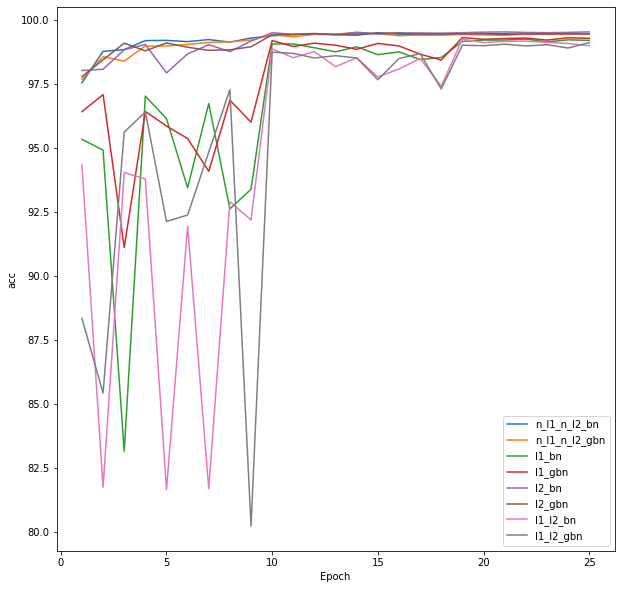

In [24]:
plot_graphs(conditions, 'acc')

### ONE graph to show the loss change curves for all 8 jobs above

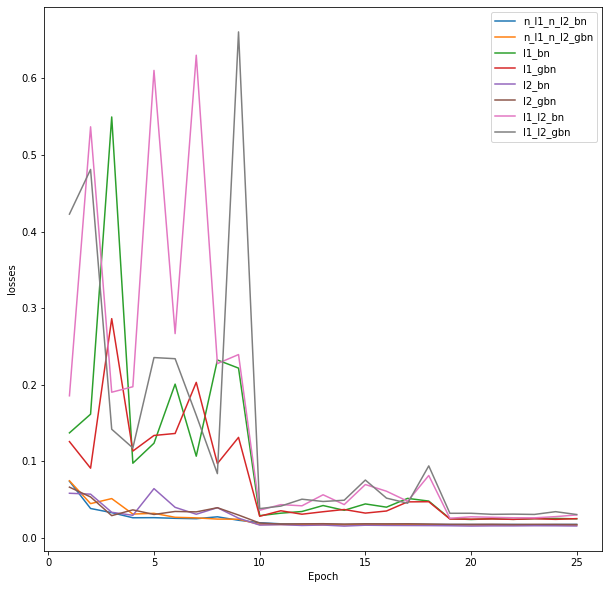

In [25]:
plot_graphs(conditions, 'losses')

### 25 misclassified images for "without L1/L2 with BN"

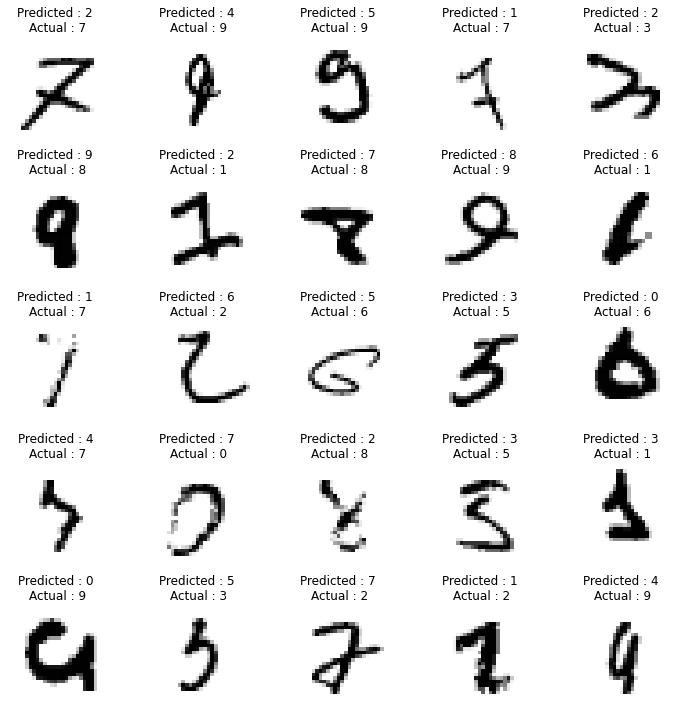

In [26]:
plot_misclassified_images('n_l1_n_l2_bn')

### 25 misclassified images for "without L1/L2 with GBN"

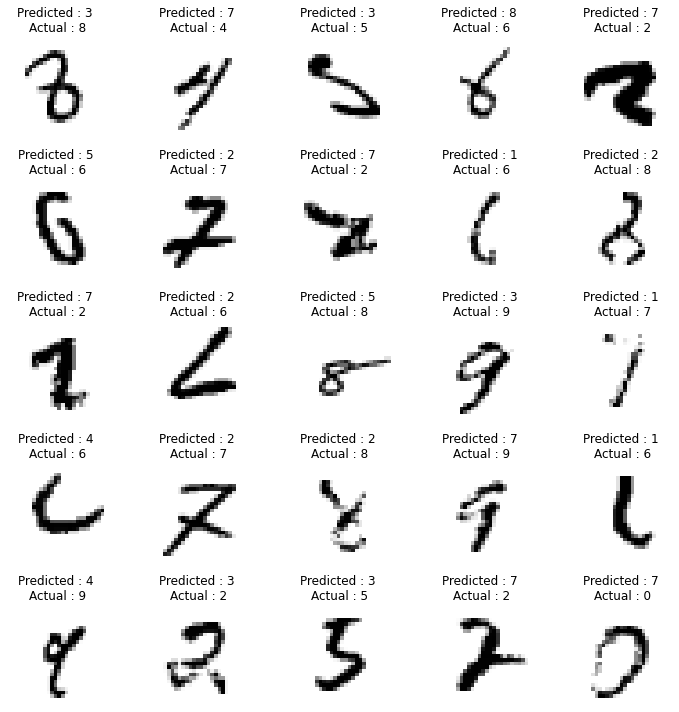

In [27]:
plot_misclassified_images('n_l1_n_l2_gbn')